#### Imports & Global Variables

In [1]:
import torch
import pandas as pd
import numpy as np

np.random.seed(42)
torch.manual_seed(42)

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

<br />

# Part 1 and Part 2 -- PyTorch Implementation
---

Implementing and training a FFNN using PyTorch. Each task will utilize the same datasets, but will be handled differently throughout. Anything with the value p1 refers to part 1 variables and p2 refers to part 2 varaibles

*Part 1 implements Multi-class cross entropy as the cost function*

*Part 2 implements Mean-squared error as the cost function*

---

### Importing Data

We begin by utilizing PyTorch's torch.utils.data.Dataset object to create a custom dataset that could handle our custom integrations of how to handle the data. For part 1, we simply import the dataset, scale it, and convert it to a torch.tensor(). For part 2, we pass a boolean value for 'one_hot' which will convert the labels into one-hot encoded labels.

Please note that we are only scaling based on the features within the training set to allow for higher accuracy from unseen examples.

In [2]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, df, scaler, one_hot=False, transform=None):
        super().__init__()
        self.features = df.iloc[:, 1:]
        self.labels = df.iloc[:, 0]
        
        self.features = scaler.transform(self.features)

        self.transform = transform
        self.one_hot = one_hot

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.one_hot:
            one_hot_label = F.one_hot(label, num_classes=2).float() # one-hot encoding the labels so we can perform MSELoss on this... tensor([0., 1.])) is 1 and tensor([1., 0.])) is 0
            return feature, one_hot_label
        else:
            return feature, label

### Modeling

We define our simple feed forward network as having one hidden layer with a ReLU activation function. 

We then define our different loss functions and optimization functions below. MCE for part 1 and MSE for part 2. Adam for part 1 and SGD for part 2. 

In [3]:
class SimpleNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.f1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.f2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.f1(x)
        x = self.relu(x)
        x = self.f2(x)
        return x

##### Training the model

This function handles the learning aspect of our neural network, such that for each epoch, we run our features through the model to get our predictions, then obtain the loss for this iteration. After computing the loss, we are able to backpropogate through the network to learn the gradients, and then update it for the next step. 

In [4]:
def train(model, train_loader, valid_loader, num_epochs, criterion, optimizer):
    """
    Parameters
    ----------
    model: Pytorch nn.Module model
    train_loader: training set as a DataLoader()
    valid_loader: validation set as a DataLoader()
    num_epochs: Number of epochs
    criterion: Loss function
    optimizer: Optimization function
    """
    
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_valid_loss = 0.0

        with torch.no_grad():
            for features, labels in valid_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                running_valid_loss += loss.item()
    
        epoch_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}")
        
    return train_losses, valid_losses

##### Testing the model (with accuracy)

In [5]:
def test_accuracy_p1(model, test_loader):
    """
    Parameters
    ----------
    model: Pytorch nn.Module model
    test_loader: test set as a DataLoader()
    """
    
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)            

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test    
    return test_accuracy

def test_accuracy_p2(model, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for features, one_hot_labels in test_loader:
                outputs = model(features)
                _, predicted = torch.max(outputs, 1)
                
                labels = torch.argmax(one_hot_labels, dim=1)

                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test    
    return test_accuracy


### Plotting Loss Curves and Decision Boundaries

*Please note that ChatGPT was utilized for the plots. We originally made our own version based on the decision boundary code you left for us in example.ipynb. But decided that rather than 4 individual plots each time, that it may be cleaner if expressed in a 2x2 fig, ax plot. So we did have ChatGPT quickly create these plots for us for the purpose of making the data easier to understand. We only chose to do this because we thought that the plots were not the focus of the homework, but were just the way to show the viewer what our own code actually learned.*

In [6]:
def plot_loss_curves_1x2_fixed(train_losses, 
                               valid_losses,
                               titles,
                               num_epochs):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.plot(list(range(1, num_epochs + 1)), train_losses[i], label='train loss')
        ax.plot(list(range(1, num_epochs + 1)), valid_losses[i], label='valid loss')
        ax.set_title(f'Loss Curves ({titles[i]})')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    plt.tight_layout()
    plt.show()


def plot_decision_boundaries_1x2_fixed(models,
                                       loaders,
                                       titles,
                                       encoding_flags):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        model = models[i]
        train_loader = loaders[i]
        title = titles[i]
        encode = encoding_flags[i]

        y_min, y_max = train_loader.dataset.features[:, 1].min(), train_loader.dataset.features[:, 1].max()
        x_min, x_max = train_loader.dataset.features[:, 0].min(), train_loader.dataset.features[:, 0].max()
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

        grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
        with torch.no_grad():
            Z = model(grid_points) 
            Z = Z.argmax(dim=1).numpy()

        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')

        for inputs, label in train_loader:
            inputs = inputs.numpy()
            labels = label.numpy()
            if encode:
                labels = label.argmax(dim=1).numpy()
            ax.scatter(inputs[:, 0], inputs[:, 1], c=labels, edgecolor='k', cmap='coolwarm', marker='o')

        ax.set_title(title)
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")

    plt.tight_layout()
    plt.show()

##### Initializing model / cost function / optimizer

In [7]:
lambda_val = 0.003

def p1(csv_file_prefix,
       batch_size = 32,
       hidden_size = 64,
       lr=0.001,
       num_epochs = 200):

    scaler = StandardScaler()  # z-score all input features

    train_df = pd.read_csv(f'{csv_file_prefix}_train.csv')
    valid_df = pd.read_csv(f'{csv_file_prefix}_valid.csv')
    test_df = pd.read_csv(f'{csv_file_prefix}_test.csv')

    train_features = train_df.iloc[:, 1:]
    features = scaler.fit(train_features)

    train_dataset_p1 = SimpleDataset(df=train_df, scaler=scaler, one_hot=False)
    valid_dataset_p1 = SimpleDataset(df=valid_df, scaler=scaler, one_hot=False)
    test_dataset_p1 = SimpleDataset(df=test_df, scaler=scaler, one_hot=False)

    train_dataset_p2 = SimpleDataset(df=train_df, scaler=scaler, one_hot=True)
    valid_dataset_p2 = SimpleDataset(df=valid_df, scaler=scaler, one_hot=True)
    test_dataset_p2 = SimpleDataset(df=test_df, scaler=scaler, one_hot=True)

    train_loader_p1 = torch.utils.data.DataLoader(train_dataset_p1, batch_size=batch_size, shuffle=True)
    valid_loader_p1 = torch.utils.data.DataLoader(valid_dataset_p1, batch_size=batch_size, shuffle=False)
    test_loader_p1 = torch.utils.data.DataLoader(test_dataset_p1, batch_size=batch_size, shuffle=False)

    train_loader_p2 = torch.utils.data.DataLoader(train_dataset_p2, batch_size=batch_size, shuffle=True)
    valid_loader_p2 = torch.utils.data.DataLoader(valid_dataset_p2, batch_size=batch_size, shuffle=False)
    test_loader_p2 = torch.utils.data.DataLoader(test_dataset_p2, batch_size=batch_size, shuffle=False)

    input_size = train_dataset_p1.features.shape[1] 
    output_size = len(set(train_dataset_p1.labels))

    model_p1_no_reg = SimpleNN(input_size, hidden_size, output_size)
    model_p1_with_reg = SimpleNN(input_size, hidden_size, output_size)

    model_p2_no_reg = SimpleNN(input_size, hidden_size, output_size)
    model_p2_with_reg = SimpleNN(input_size, hidden_size, output_size)

    criterion_p1 = torch.nn.CrossEntropyLoss()
    criterion_p2 = torch.nn.MSELoss()

    optimizer_p1_no_reg = torch.optim.Adam(model_p1_no_reg.parameters(), lr=lr)
    optimizer_p1_with_reg = torch.optim.Adam(model_p1_with_reg.parameters(), lr=lr)

    optimizer_p2_no_reg = torch.optim.SGD(model_p2_no_reg.parameters(), lr=lr, momentum=0.9)
    optimizer_p2_with_reg = torch.optim.SGD(model_p2_with_reg.parameters(), lr=lr, momentum=0.9)

    train_losses_p1_no_reg, valid_losses_p1_no_reg = train(model_p1_no_reg, train_loader_p1, valid_loader_p1, num_epochs, criterion_p1, optimizer_p1_no_reg)
    train_losses_p1_with_reg, valid_losses_p1_with_reg = train(model_p1_with_reg, train_loader_p1, valid_loader_p1, num_epochs, criterion_p1, optimizer_p1_with_reg)

    train_losses_p2_no_reg, valid_losses_p2_no_reg = train(model_p2_no_reg, train_loader_p2, valid_loader_p2, num_epochs, criterion_p2, optimizer_p2_no_reg)
    train_losses_p2_with_reg, valid_losses_p2_with_reg = train(model_p2_with_reg, train_loader_p2, valid_loader_p2, num_epochs, criterion_p2, optimizer_p2_with_reg)

    test_acc_p1 = test_accuracy_p1(model_p1_no_reg, test_loader_p1)
    test_acc_p2 = test_accuracy_p2(model_p2_no_reg, test_loader_p2)

    print(f"Loss: MCE (Problem 1) / Dataset: {csv_file_prefix} / Test Accuracy: ", test_acc_p1)
    print(f"Loss: MSE (Problem 2) / Dataset: {csv_file_prefix} / Test Accuracy: ", test_acc_p2)

    # Loss curves

    train_losses = [
        train_losses_p1_no_reg,
        train_losses_p2_no_reg,
    ]
    valid_losses = [
        valid_losses_p1_no_reg, 
        valid_losses_p2_no_reg,
    ]
    titles = [
        f"Loss: MCE (Problem 1) / Dataset: {csv_file_prefix}",
        f"Loss: MSE (Problem 2) / Dataset: {csv_file_prefix}",
    ]

    plot_loss_curves_1x2_fixed(
        train_losses,
        valid_losses,
        titles,
        num_epochs
    )

    # Decision Boudaries

    models = [model_p1_no_reg, model_p2_no_reg]
    loaders = [train_loader_p1, train_loader_p2]
    titles = [
        f"Loss: MCE (Problem 1) / Dataset: {csv_file_prefix} / Hidden Nodes: {hidden_size}",
        f"Loss: MSE (Problem 2) / Dataset: {csv_file_prefix} / Hidden Nodes: {hidden_size}"
    ]
    encoding_flags = [False, True]

    plot_decision_boundaries_1x2_fixed(
        models,
        loaders,
        titles,
        encoding_flags
    )


Epoch 50/200, Train Loss: 0.4092, Valid Loss: 0.4108
Epoch 100/200, Train Loss: 0.3035, Valid Loss: 0.2984
Epoch 150/200, Train Loss: 0.2064, Valid Loss: 0.1962
Epoch 200/200, Train Loss: 0.1562, Valid Loss: 0.1329
Epoch 50/200, Train Loss: 0.3895, Valid Loss: 0.3972
Epoch 100/200, Train Loss: 0.2838, Valid Loss: 0.2792
Epoch 150/200, Train Loss: 0.1949, Valid Loss: 0.1836
Epoch 200/200, Train Loss: 0.1405, Valid Loss: 0.1222
Epoch 50/200, Train Loss: 0.1421, Valid Loss: 0.1433
Epoch 100/200, Train Loss: 0.1258, Valid Loss: 0.1253
Epoch 150/200, Train Loss: 0.1156, Valid Loss: 0.1097
Epoch 200/200, Train Loss: 0.0947, Valid Loss: 0.0973
Epoch 50/200, Train Loss: 0.1544, Valid Loss: 0.1516
Epoch 100/200, Train Loss: 0.1438, Valid Loss: 0.1388
Epoch 150/200, Train Loss: 0.1330, Valid Loss: 0.1274
Epoch 200/200, Train Loss: 0.1230, Valid Loss: 0.1160
Loss: MCE (Problem 1) / Dataset: spiral / Test Accuracy:  100.0
Loss: MSE (Problem 2) / Dataset: spiral / Test Accuracy:  87.0


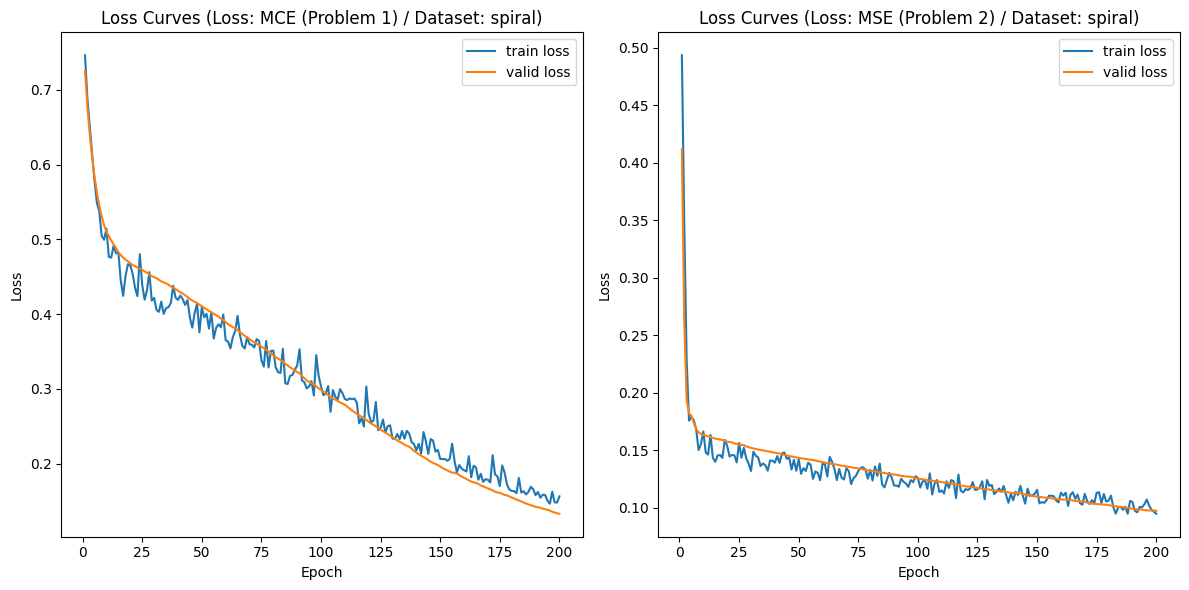

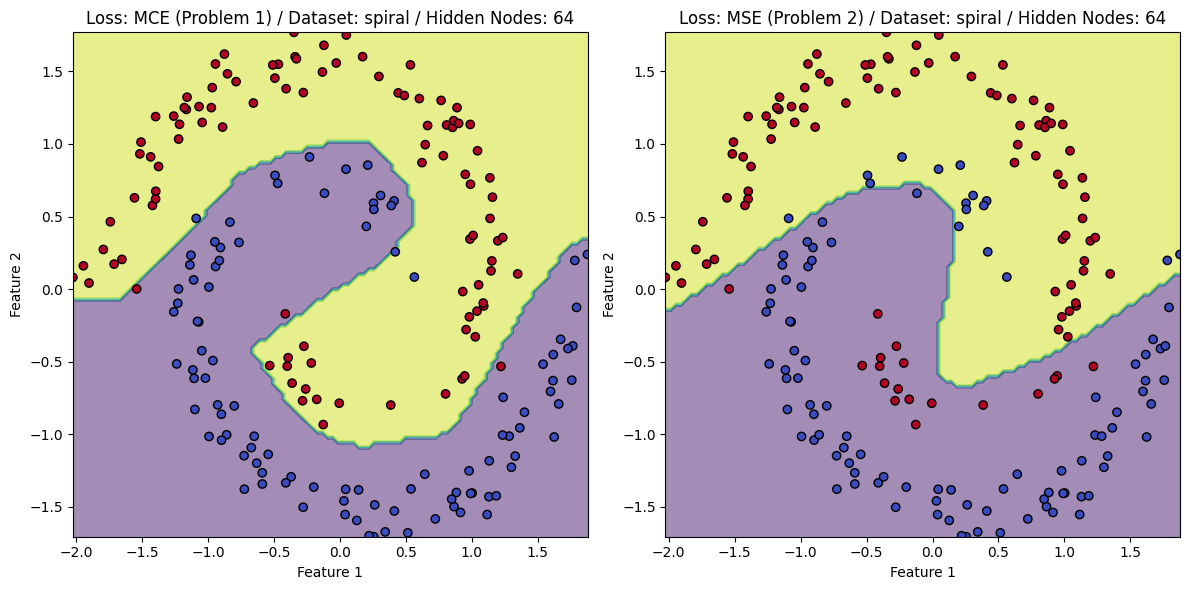

In [8]:
csv_file_prefix = 'spiral'
# csv_file_prefix = 'two_gaussians'
# csv_file_prefix = 'xor'
# csv_file_prefix = 'center_surround'

batch_size = 32
hidden_size = 64
lr=0.001
num_epochs = 200
lambda_val = 0.003

p1('spiral', batch_size=batch_size, hidden_size=hidden_size, lr=lr, num_epochs=num_epochs)

Epoch 50/200, Train Loss: 0.3812, Valid Loss: 0.3973
Epoch 100/200, Train Loss: 0.2619, Valid Loss: 0.2695
Epoch 150/200, Train Loss: 0.1959, Valid Loss: 0.1762
Epoch 200/200, Train Loss: 0.1326, Valid Loss: 0.1182
Epoch 50/200, Train Loss: 0.3639, Valid Loss: 0.3729
Epoch 100/200, Train Loss: 0.2571, Valid Loss: 0.2504
Epoch 150/200, Train Loss: 0.1869, Valid Loss: 0.1656
Epoch 200/200, Train Loss: 0.1445, Valid Loss: 0.1139
Epoch 50/200, Train Loss: 0.1489, Valid Loss: 0.1570
Epoch 100/200, Train Loss: 0.1416, Valid Loss: 0.1457
Epoch 150/200, Train Loss: 0.1260, Valid Loss: 0.1356
Epoch 200/200, Train Loss: 0.1191, Valid Loss: 0.1246
Epoch 50/200, Train Loss: 0.1548, Valid Loss: 0.1595
Epoch 100/200, Train Loss: 0.1268, Valid Loss: 0.1410
Epoch 150/200, Train Loss: 0.1258, Valid Loss: 0.1256
Epoch 200/200, Train Loss: 0.1086, Valid Loss: 0.1122
Loss: MCE (Problem 1) / Dataset: spiral / Test Accuracy:  100.0
Loss: MSE (Problem 2) / Dataset: spiral / Test Accuracy:  83.5


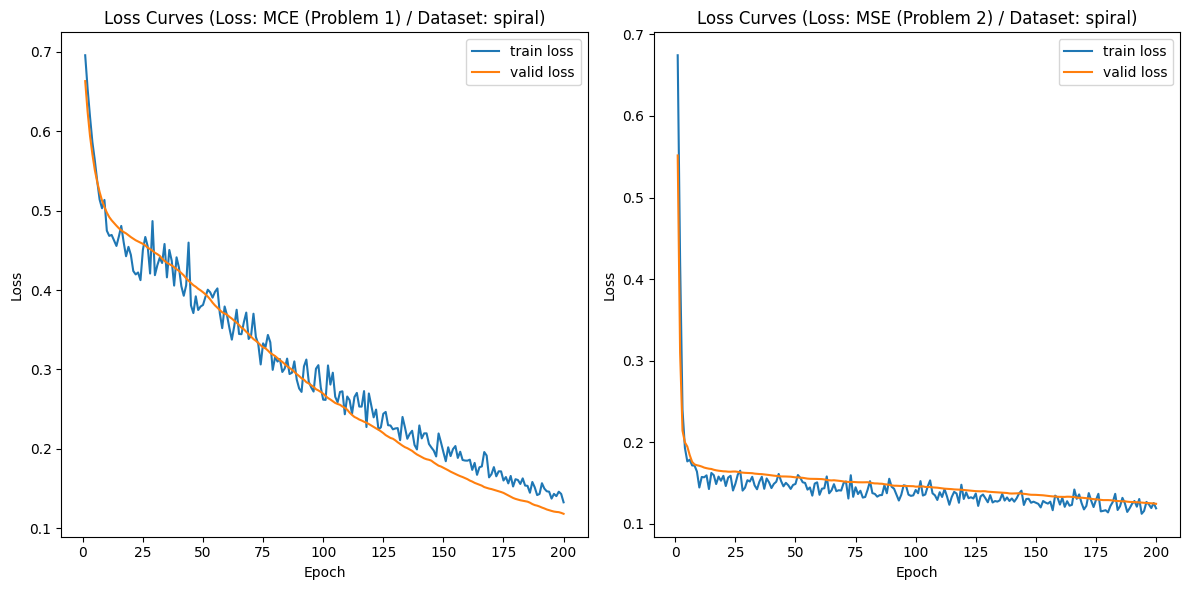

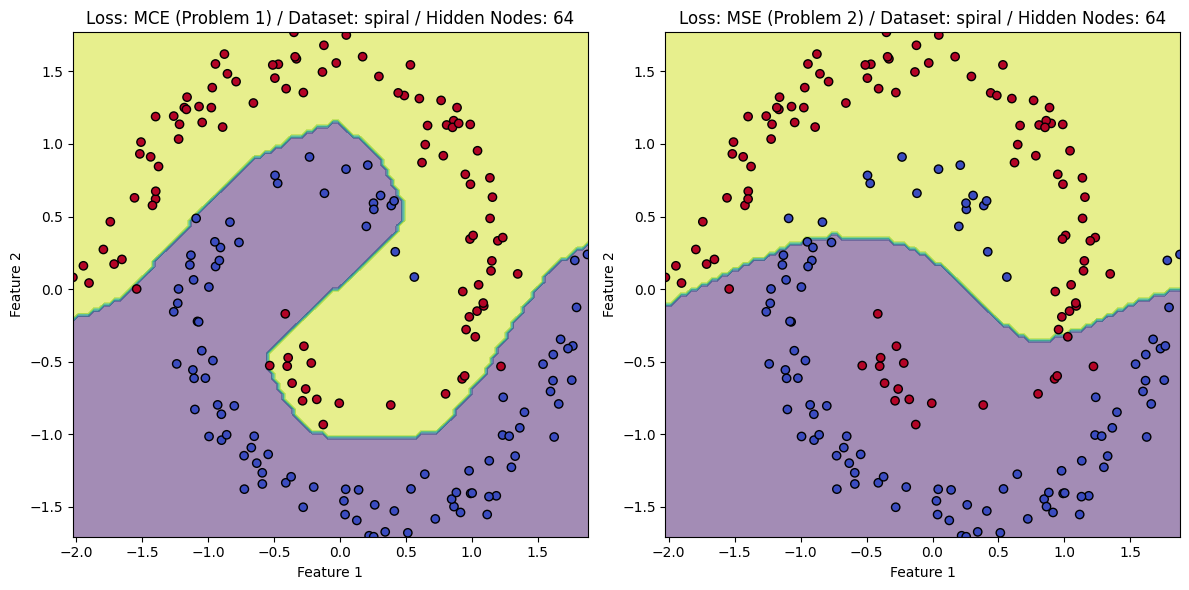

In [9]:
csv_file_prefix = 'two_gaussians'

batch_size = 32
hidden_size = 64
lr=0.001
num_epochs = 200
lambda_val = 0.003

p1('spiral', batch_size=batch_size, hidden_size=hidden_size, lr=lr, num_epochs=num_epochs)

Epoch 50/200, Train Loss: 0.3596, Valid Loss: 0.3805
Epoch 100/200, Train Loss: 0.2666, Valid Loss: 0.2563
Epoch 150/200, Train Loss: 0.1947, Valid Loss: 0.1708
Epoch 200/200, Train Loss: 0.1561, Valid Loss: 0.1195
Epoch 50/200, Train Loss: 0.3855, Valid Loss: 0.3702
Epoch 100/200, Train Loss: 0.2446, Valid Loss: 0.2502
Epoch 150/200, Train Loss: 0.2021, Valid Loss: 0.1684
Epoch 200/200, Train Loss: 0.1269, Valid Loss: 0.1161
Epoch 50/200, Train Loss: 0.1416, Valid Loss: 0.1476
Epoch 100/200, Train Loss: 0.1334, Valid Loss: 0.1300
Epoch 150/200, Train Loss: 0.1130, Valid Loss: 0.1169
Epoch 200/200, Train Loss: 0.1018, Valid Loss: 0.1047
Epoch 50/200, Train Loss: 0.1476, Valid Loss: 0.1469
Epoch 100/200, Train Loss: 0.1271, Valid Loss: 0.1353
Epoch 150/200, Train Loss: 0.1177, Valid Loss: 0.1223
Epoch 200/200, Train Loss: 0.1136, Valid Loss: 0.1115
Loss: MCE (Problem 1) / Dataset: spiral / Test Accuracy:  100.0
Loss: MSE (Problem 2) / Dataset: spiral / Test Accuracy:  87.0


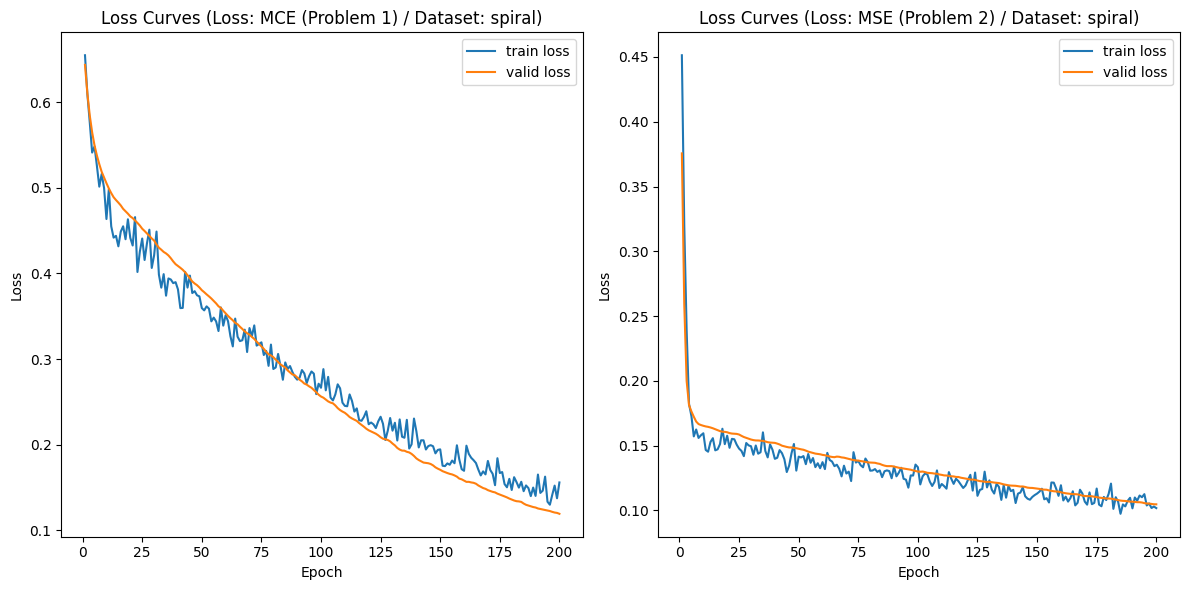

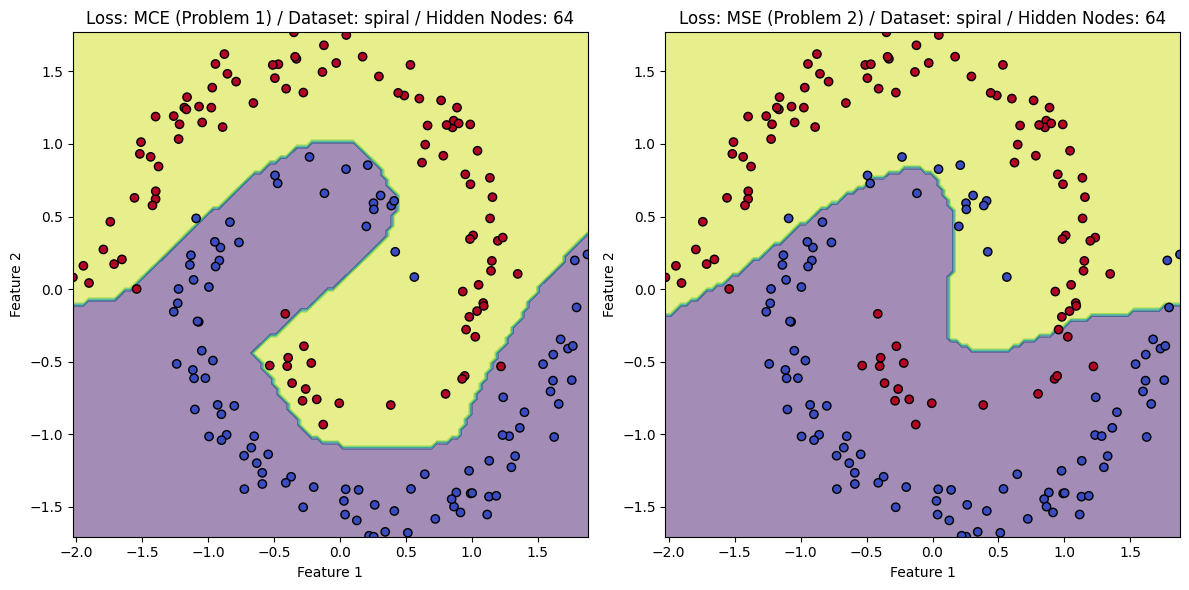

In [10]:
csv_file_prefix = 'xor'

batch_size = 32
hidden_size = 64
lr=0.001
num_epochs = 200
lambda_val = 0.003

p1('spiral', batch_size=batch_size, hidden_size=hidden_size, lr=lr, num_epochs=num_epochs)

Epoch 50/200, Train Loss: 0.3523, Valid Loss: 0.3687
Epoch 100/200, Train Loss: 0.2345, Valid Loss: 0.2409
Epoch 150/200, Train Loss: 0.1723, Valid Loss: 0.1581
Epoch 200/200, Train Loss: 0.1353, Valid Loss: 0.1067
Epoch 50/200, Train Loss: 0.3628, Valid Loss: 0.3684
Epoch 100/200, Train Loss: 0.2886, Valid Loss: 0.2652
Epoch 150/200, Train Loss: 0.2013, Valid Loss: 0.1808
Epoch 200/200, Train Loss: 0.1285, Valid Loss: 0.1217
Epoch 50/200, Train Loss: 0.1413, Valid Loss: 0.1691
Epoch 100/200, Train Loss: 0.1401, Valid Loss: 0.1559
Epoch 150/200, Train Loss: 0.1337, Valid Loss: 0.1433
Epoch 200/200, Train Loss: 0.1205, Valid Loss: 0.1316
Epoch 50/200, Train Loss: 0.1267, Valid Loss: 0.1311
Epoch 100/200, Train Loss: 0.1113, Valid Loss: 0.1136
Epoch 150/200, Train Loss: 0.1106, Valid Loss: 0.1003
Epoch 200/200, Train Loss: 0.0938, Valid Loss: 0.0889
Loss: MCE (Problem 1) / Dataset: spiral / Test Accuracy:  100.0
Loss: MSE (Problem 2) / Dataset: spiral / Test Accuracy:  79.5


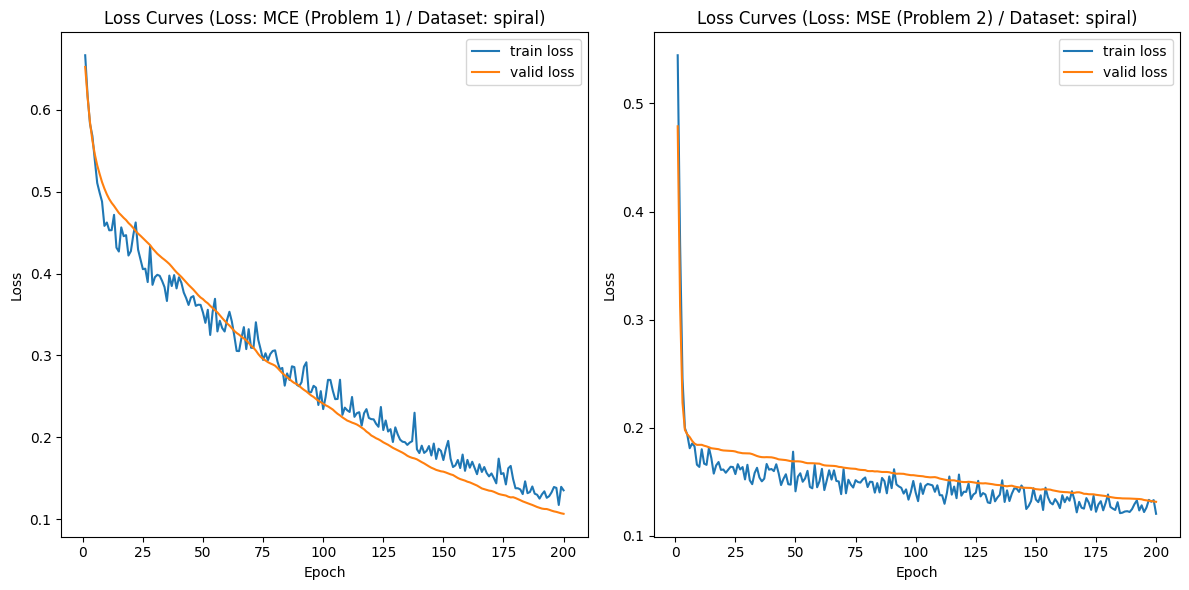

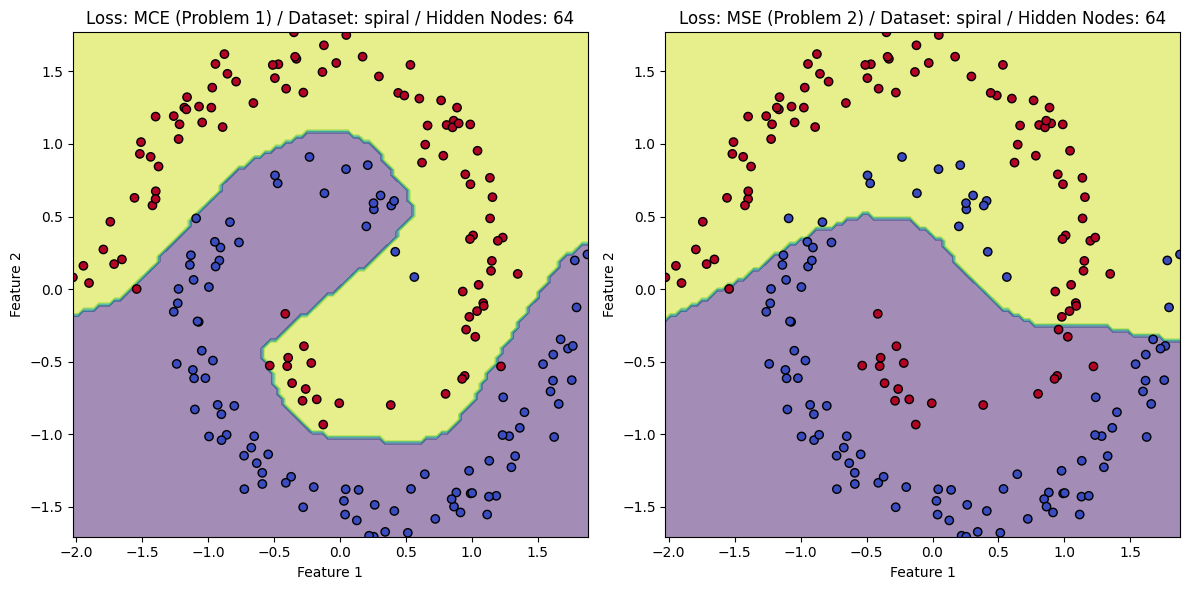

In [11]:
csv_file_prefix = 'center_surround'

batch_size = 32
hidden_size = 64
lr=0.001
num_epochs = 200
lambda_val = 0.003

p1('spiral', batch_size=batch_size, hidden_size=hidden_size, lr=lr, num_epochs=num_epochs)

# Part 3 -- Manual Gradients and Updates

*Neural Network From Scratch*

### Global Functions

In [12]:
def z_score(df, scaler):
    """
    Parameters
    ----------
    df: pd.DataFrame with labels in the first column and features in following columns
    scaler: sklearn.preprocessing.StandardScaler fit to the training dataset feature values

    Returns
    -------
    tuple: np.array of scaled features and np.array of labels
    """
    features = df.iloc[:, 1:]
    labels = df.iloc[:, 0].values

    features = scaler.transform(features)

    indices_order = np.random.permutation(len(features))

    features = features[indices_order]
    labels = labels[indices_order]
    
    return features, labels


def label_encoder(labels):
    """
    Parameters
    ----------
    labels: np.array of training dataset labels

    Returns
    -------
    dict: with one-hot encoded "numerical encoding: label" key: value pairs
    """
    unique_labels = sorted(np.unique(labels))
    labels_encoding = {i: l for i, l in enumerate(unique_labels)}
    return labels_encoding

def encode_labels(labels, encoder):
    """
    Parameters
    ----------
    labels: np.array of training dataset labels
    encoder : dict with "numerical encoding: label" key: value pairs

    Returns
    -------
    np.array of encoded labels
    """
    return np.array([encoder[l] for l in labels])

def decode_labels(encoded_labels, encoder):
    """
    Parameters
    ----------
    encoded_labels: np.array of encoded labels
    encoder: dict with "numerical encoding: label" key: value pairs

    Returns
    -------
    np.array: of decoded labels
    """
    decoder = {value: key for key, value in encoder.items()}
    return np.array([decoder[l] for l in encoded_labels])

def encoded_labels_array(encoded_labels):
    """
    Parameters
    ----------
    encoded_labels: np.array of encoded labels

    Returns
    -------
    np.array of encoded labels as arrays (e.g., encoded label 1 becomes [0, 1] and encoded label 0 becomes [1, 0])
    """
    num_unique_labels = len(np.unique(encoded_labels))
    return np.array([np.array([1 if i == el else 0 for i in range(num_unique_labels)]) for el in encoded_labels])

def softmax(logits):
    """
    Parameters
    ----------
    logits: np.array of logits (raw output from output layer)

    Returns
    -------
    np.array: of values after performing softmax (values sum to 1)
    """
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

def mcce(softmax_logits, labels):
    """
    Parameters
    ----------
    softmax_logits: np.array of softmaxed logits (class probabilities)
    labels: np.array of true labels 

    Returns
    -------
    np.float64: Multi-class cross entropy loss
    """
    return - np.sum(labels * np.log(softmax_logits)) / labels.shape[0]

def sigmoid(unactivated):
    """
    Parameters
    ----------
    unactivated: np.array of unactivated input matrix (output matrix from last layer @ weights)

    Returns
    -------
    np.array: Matrix after performing sigmoid operation on unactivated input matrix
    """
    return 1 / (1 + np.exp(-unactivated))

def sigmoid_derivative(activated):
    """
    Parameters
    ----------
    activated: np.array of activated input matrix

    Returns
    -------
    np.array: Matrix after performing sigmoid derivative operation on activated input matrix
    """
    return sigmoid(activated) * (1 - sigmoid(activated))

def relu(unactivated):
    """
    Parameters
    ----------
    unactivated: np.array of unactivated input matrix (output matrix from last layer @ weights)

    Returns
    -------
    np.array: Matrix after performing relu operation on unactivated input matrix
    """
    return np.maximum(0, unactivated)

def relu_derivative(activated):
    """
    Parameters
    ----------
    activated : np.array of activated input matrix

    Returns
    -------
    np.array: Matrix after performing relu derivative operation on activated input matrix
    """
    return (activated > 0).astype(float)

### Modeling

In [13]:
class model:
    """
    An object representing a trainable neural network with the follow architecture:

    Input Layer (input_size inputs) --> Weights (w_i_h) + Biases (b_i_h) --> ReLU Activation --> Hidden Layer --> Weights (w_h_o) + Biases (b_h_o) --> Softmax activation --> Output

    """
    def __init__(self, input_size=2, hidden_size=9, output_size=2):
        """
        Parameters
        ----------
        input_size: Optional[int] of input features
        hidden_size : Optional[int] of nodes in the hidden layer
        output_size : Optional[int] of output features (classes)
        """
        shape_i_h = (input_size, hidden_size) # shape of input to hidden layer weights matrix
        shape_h_o = (hidden_size, output_size) # shape of hidden to output layer weights matrix

        self.w_i_h = np.random.normal(loc=0.0, scale=1.0, size=shape_i_h) # randomly sample unique weights from a gaussian dist with mean 0 and std 1
        self.w_h_o = np.random.normal(loc=0.0, scale=1.0, size=shape_h_o) # randomly sample unique weights from a gaussian dist with mean 0 and std 1

        self.b_i_h = np.zeros(shape=(1, hidden_size)) # set biases to zero
        self.b_h_o = np.zeros(shape=(1, output_size)) # set biases to zero

        self.num_params = input_size * hidden_size + hidden_size * output_size + hidden_size + output_size # calculate number of params for fun

    def forward(self, features, train=False):
        """
        Parameters
        ----------
        features: np.array of examples with each example being an array of feature values
        train : Optional[bool] - True if training the network (i.e., if intermediate results are needed to compute gradients), by default False

        Returns
        -------
        np.array: of outputs for each example with each output being an array of class probabilities
        """
        forward_results = {}

        forward_results['features'] = features
        i_h = features @ self.w_i_h
        forward_results['i_h'] = i_h
        i_h_b = i_h + self.b_i_h
        forward_results['i_h_b'] = i_h_b
        a_i_h_b = relu(i_h_b)
        forward_results['a_i_h_b'] = a_i_h_b        

        h_o = a_i_h_b @ self.w_h_o
        forward_results['h_o'] = h_o        
        h_o_b = h_o + self.b_h_o
        forward_results['h_o_b'] = h_o_b
        a_h_o_b = softmax(h_o_b)
        forward_results['a_h_o_b'] = a_h_o_b

        if train:
            return a_h_o_b, forward_results
        return a_h_o_b

    def backward(self, forward_results, labels):
        """
        Parameters
        ----------
        forward_results: dict of all results (input, intermediates, and output) from forward a pass
        labels: np.array of encoded labels

        Returns
        -------
        dict: of gradient matrices of weight and bias matrices
        """
        gradients = {}
        
        probs = forward_results['a_h_o_b']
        
        dL_dh_o_b = probs - labels
        
        a_i_h_b = forward_results['a_i_h_b']
        gradients['w_h_o'] = a_i_h_b.T @ dL_dh_o_b
        gradients['b_h_o'] = np.sum(dL_dh_o_b, axis=0, keepdims=True)

        dL_da_i_h_b = dL_dh_o_b @ self.w_h_o.T 
        dL_di_h_b = dL_da_i_h_b * relu_derivative(forward_results['a_i_h_b'])

        gradients['w_i_h'] = forward_results['features'].T @ dL_di_h_b 
        gradients['b_i_h'] = np.sum(dL_di_h_b, axis=0, keepdims=True)

        return gradients
        
    def update_weights(self, gradients, learning_rate):
        """
        Parameters
        ----------
        gradients: dict of gradient matrices of weight and bias matrices
        learning_rate: float that controls the size of the step taken during the update
        """
        self.w_h_o -= (learning_rate * gradients['w_h_o'])
        self.b_h_o -= (learning_rate * gradients['b_h_o'])
        self.w_i_h -= (learning_rate * gradients['w_i_h'])
        self.b_i_h -= (learning_rate * gradients['b_i_h'])

    def train(self, features, encoded_labels, valid_features, encoded_valid_labels, num_epochs, learning_rate):
        """
        Parameters
        ----------
        features: np.array of examples with each example being an array of feature values
        encoded_labels: np.array of encoded labels
        valid_features: np.array of validation examples with each example being an array of feature values
        encoded_valid_labels: np.array of encoded validation labels
        num_epochs: int of complete passes over the training dataset to take during training
        learning_rate : float that controls the size of the step taken during the update

        Returns
        -------
        tuple: List of train losses for each epoch and list of validation losses for each epoch
        """
        encoded_labels_arr = encoded_labels_array(encoded_labels)
        encoded_valid_labels_arr = encoded_labels_array(encoded_valid_labels)

        train_loss = []
        valid_loss = []
        
        for _ in range(num_epochs):
            _, forward_results = self.forward(features, train=True)
            
            gradients = self.backward(forward_results, encoded_labels_arr)

            self.update_weights(gradients, learning_rate)
            
            loss = mcce(forward_results['a_h_o_b'], encoded_labels_arr)
            train_loss.append(loss)

            _, forward_results = self.forward(valid_features, train=True)
                                    
            loss = mcce(forward_results['a_h_o_b'], encoded_valid_labels_arr)
            valid_loss.append(loss)
        
        return train_loss, valid_loss
    
    def predict(self, features):
        """
        Parameters
        ----------
        features: np.array of examples with each example being an array of feature values

        Returns
        -------
        np.array: of predicted encoded labels
        """
        y_predicted = self.forward(features)
        predicted_labels = np.array([np.argmax(y_p) for y_p in y_predicted])
        return predicted_labels
    
    def accuracy(self, test_features, encoded_test_labels):
        """
        Parameters
        ----------
        test_features: np.array of test examples with each example being an array of feature values
        encoded_test_labels: np.array of encoded test labels

        Returns
        -------
        float: Accuracy score
        """
        test_results = self.predict(test_features)
        acc = np.sum([test_result == encoded_test_label for test_result, encoded_test_label in zip(test_results, encoded_test_labels)]) / len(encoded_test_labels)
        return acc
    
    def decision_boundary(self, train_features, encoded_train_labels):
        """
        Generates a plot showcasing the decision boundary of the model and the training datapoints

        Parameters
        ----------
        train_features: np.array of training examples with each example being an array of feature values
        encoded_train_labels: np.array of encoded training labels
        """
        x_min, x_max = train_features[:, 0].min() - 1, train_features[:, 0].max() + 1
        y_min, y_max = train_features[:, 1].min() - 1, train_features[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

        # Predict labels for all points in the meshgrid
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(grid_points)
        Z = Z.reshape(xx.shape)

        # Plot decision boundary
        plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')

        # Scatter plot of training points
        plt.scatter(train_features[:, 0], train_features[:, 1], c=encoded_train_labels, edgecolor='k', cmap='coolwarm', marker='o')

        plt.title("Decision Boundary with Training Data Points")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.show()

## Analyzing Each Dataset

In [14]:
def get_features_and_labels(csv_file_prefix, hidden_size=7, plotting=True):
  #print("\n\n\n\n")
  #print(f"HIDDEN FOR k={hidden_size}")
  # Importing and Scaling
  scaler = StandardScaler()  # z-score all input features

  train_df = pd.read_csv(f'{csv_file_prefix}_train.csv')

  train_features = train_df.iloc[:, 1:]
  features = scaler.fit(train_features)

  valid_df = pd.read_csv(f'{csv_file_prefix}_valid.csv')
  test_df = pd.read_csv(f'{csv_file_prefix}_test.csv')

  train_features, train_labels = z_score(train_df, scaler)
  train_labels_encoder = label_encoder(train_labels)
  encoded_train_labels = encode_labels(train_labels, train_labels_encoder)

  valid_features, valid_labels = z_score(valid_df, scaler)
  valid_labels_encoder = label_encoder(valid_labels)
  encoded_valid_labels = encode_labels(valid_labels, valid_labels_encoder)

  test_features, test_labels = z_score(test_df, scaler)
  test_labels_encoder = label_encoder(test_labels)
  encoded_test_labels = encode_labels(test_labels, test_labels_encoder)

  # Creating the model
  m = model(input_size=len(train_features[0]), hidden_size=hidden_size, output_size=len(np.unique(train_labels)))
  num_epochs = 1000
  learning_rate = 0.001
  train_loss, valid_loss = m.train(train_features, encoded_train_labels, valid_features, encoded_valid_labels, num_epochs, learning_rate)

  # Printing the test accuracy
  test_accuracy = m.accuracy(test_features, encoded_test_labels)
  #print(f"Test Accuracy ({csv_file_prefix}): {test_accuracy}")
  
  if not plotting:
    return test_accuracy

  # Plotting Loss Curve
  plt.plot(range(1, num_epochs + 1), train_loss, label='train loss')
  plt.plot(range(1, num_epochs + 1), valid_loss, label='valid loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title(csv_file_prefix)
  plt.legend()
  plt.show()

  # Plotting Decision Boundary
  m.decision_boundary(train_features, encoded_train_labels)


  

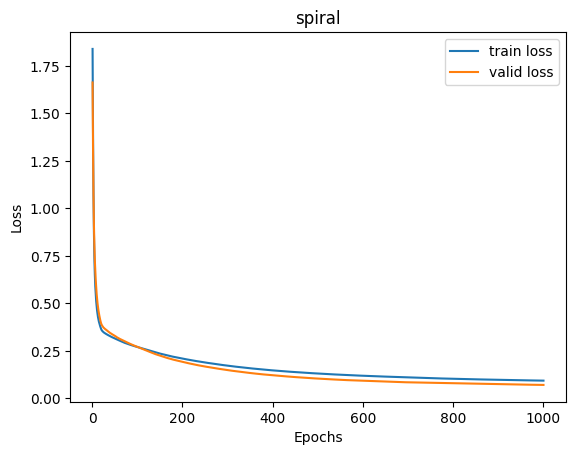

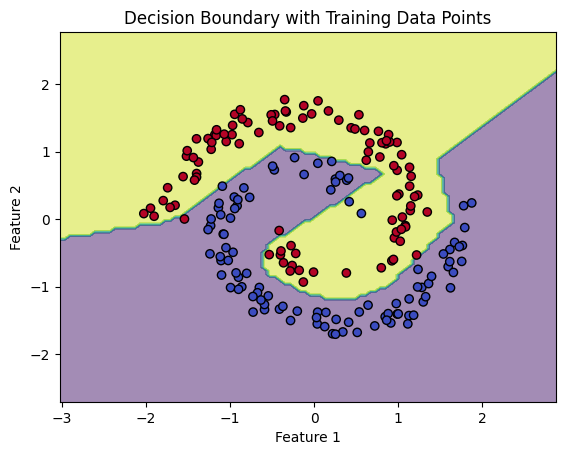

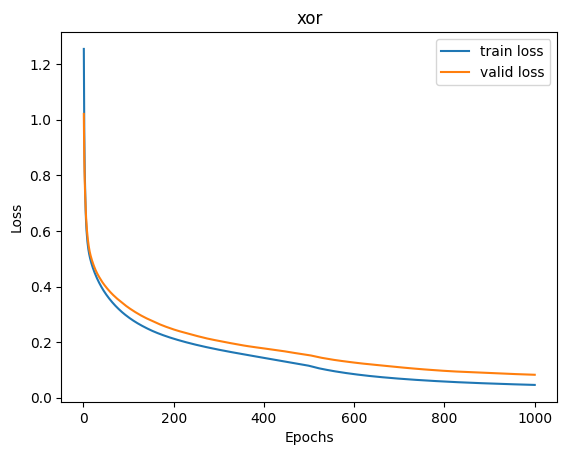

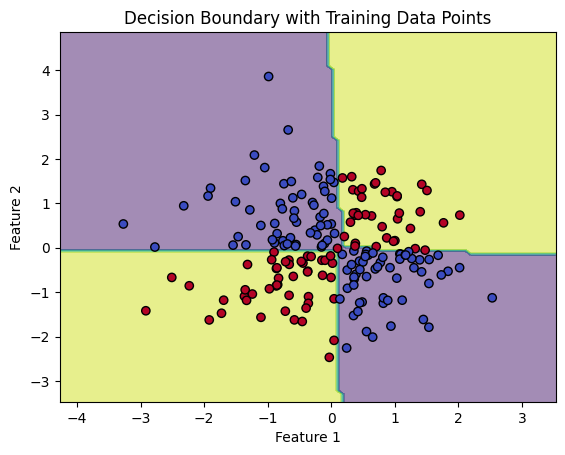

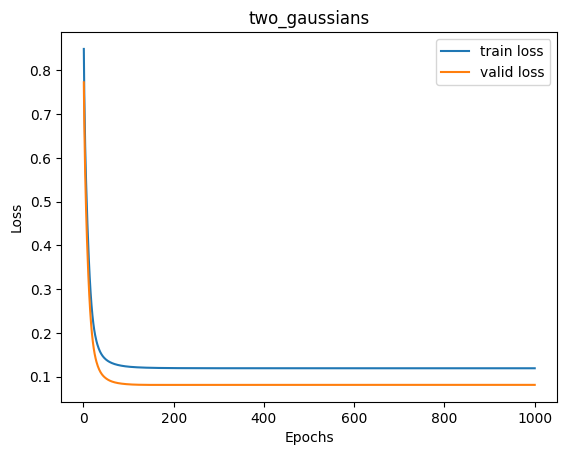

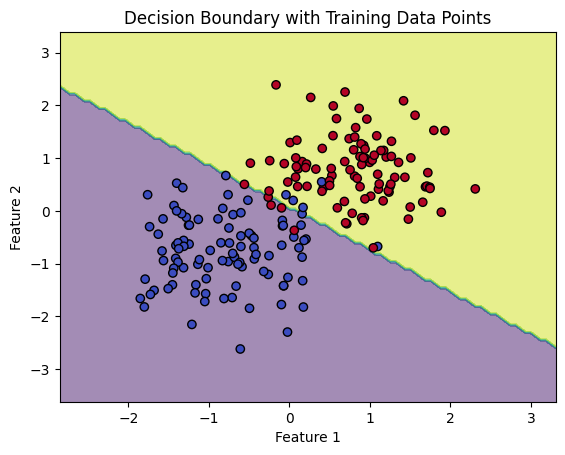

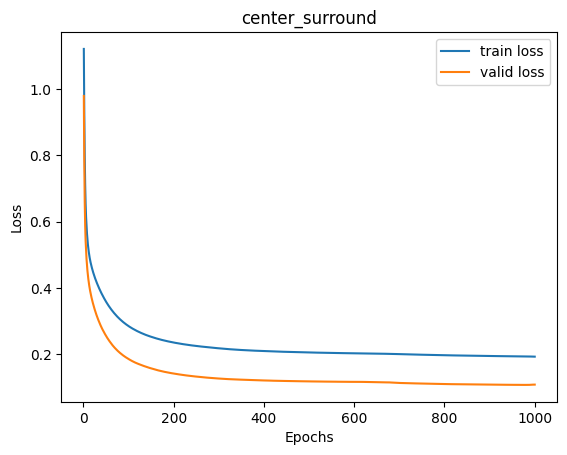

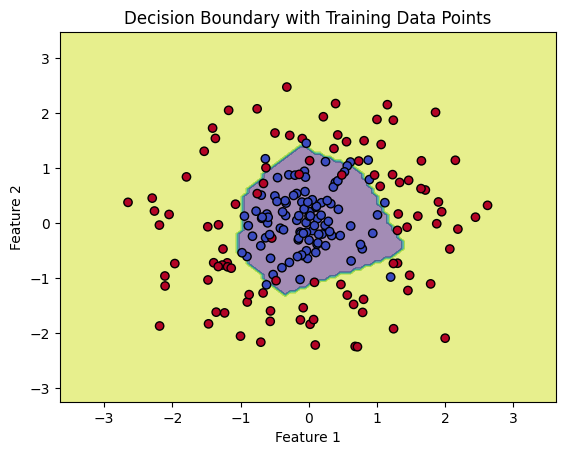

In [15]:
import collections
hidden_sizes = [2, 3, 5, 7, 9]
loss_by_hidden = collections.defaultdict(lambda: collections.defaultdict(dict)) # {2: {"spiral": 0.123}}

for hidden_size in hidden_sizes:
  spiral_accuracy = get_features_and_labels("spiral", hidden_size, plotting=False)
  xor_accuracy = get_features_and_labels("xor", hidden_size, plotting=False)
  gaussian_accuracy = get_features_and_labels("two_gaussians", hidden_size, plotting=False)
  center_accuracy = get_features_and_labels("center_surround", hidden_size, plotting=False)

  loss_by_hidden[hidden_size]["spiral"] = spiral_accuracy
  loss_by_hidden[hidden_size]["xor"] = xor_accuracy
  loss_by_hidden[hidden_size]["two_gaussians"] = gaussian_accuracy
  loss_by_hidden[hidden_size]["center_surround"] = center_accuracy

spiral_accuracy = get_features_and_labels("spiral", hidden_size=9)
xor_accuracy = get_features_and_labels("xor", hidden_size=7)
gaussian_accuracy = get_features_and_labels("two_gaussians", hidden_size=2)
center_accuracy = get_features_and_labels("center_surround", hidden_size=5)


### Analyzing the best value for k

We are exhuasting our options by analyzing what value of k is best for each dataset. Because our manual model uses the same internal structure as our pytorch implementation (without regularization), we see it fit to measure this test on our manual model. 

Notice that as k (the number of hidden nodes) increases, the model accuracy tends to also increase. However, it is important to note that the model accuracy does not increase drastically anywhere past k=3. Therefore, one could argue that it would be most beneficial to use 3 and the number of hidden nodes for your model. However, looking closer at the plots when k=3, it is obvious that in certain cases (like the spiral dataset), the model does a terrible job fitting the shape necessary. While it fits the three other datasets extremely well, I'd suggest using different values of k for each dataset.

However, the task at hand only asks what the "best" value to use for each dataset is based on accuracy, so therefore, we would assign the following to each dataset:

-spiral dataset = 9 hidden nodes

-xor dataset = 7 hidden nodes

-gaussian dataset = 2 hidden nodes

-center accuracy = 5 hidden nodes

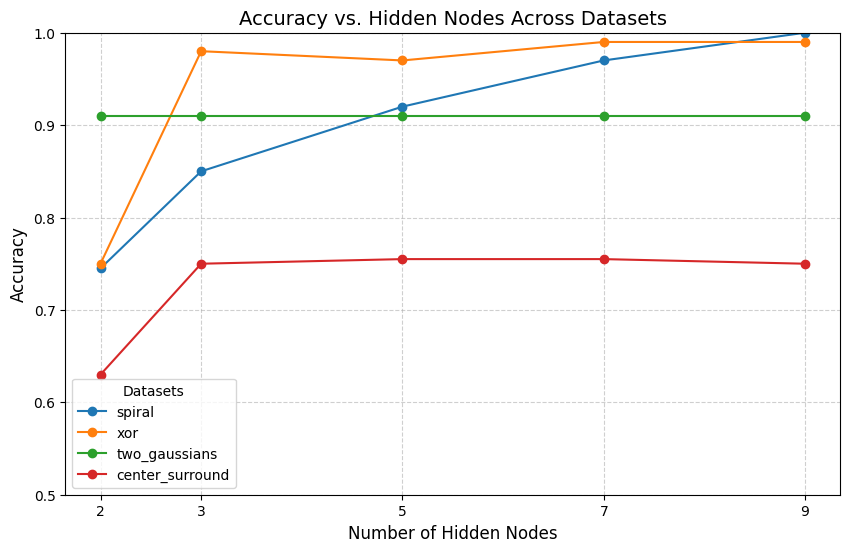

In [16]:
datasets = collections.defaultdict(list)  
hidden_nodes = sorted(loss_by_hidden.keys())  

for nodes in hidden_nodes:
    for dataset, accuracy in loss_by_hidden[nodes].items():
        datasets[dataset].append(accuracy)

plt.figure(figsize=(10, 6))

for dataset, accuracies in datasets.items():
    plt.plot(hidden_nodes, accuracies, marker='o', label=dataset)
plt.title("Accuracy vs. Hidden Nodes Across Datasets", fontsize=14)
plt.xlabel("Number of Hidden Nodes", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(hidden_nodes)
plt.ylim(0.5, 1) 
plt.legend(title="Datasets", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

# Part 4 -- PyTorch Implementation
---

*Part 4 implements regularization into our model*

---

L2-regularization is used to increase bias and decrease variance within the model to help limit overfitting the dataset in order to help generalize better over new examples. 

L2-Regularization:
$$
R_2(\theta) = \frac{1}{2} \sum_{i=1}^d |\theta_i|^2
$$

## Imports & Global Variables

In [17]:
import torch
import pandas as pd
import numpy as np

np.random.seed(42)
torch.manual_seed(42)

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [18]:
# csv_file_prefix = 'spiral'
# csv_file_prefix = 'two_gaussians'
csv_file_prefix = 'xor'
# csv_file_prefix = 'center_surround'

hidden_size = 7
lr=0.001
num_epochs = 200
lambda_val = 0.002

## Importing Data

##### Custom Dataset

In [19]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, df, scaler, transform=None):
        super().__init__()
        self.features = df.iloc[:, 1:]
        self.labels = df.iloc[:, 0]
        
        self.features = scaler.transform(self.features)

        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature, label

##### Importing the data and scaling 

In [20]:
scaler = StandardScaler()  # z-score all input features

train_df = pd.read_csv(f'{csv_file_prefix}_train.csv')

train_features = train_df.iloc[:, 1:]
features = scaler.fit(train_features)

valid_df = pd.read_csv(f'{csv_file_prefix}_valid.csv')
test_df = pd.read_csv(f'{csv_file_prefix}_test.csv')

train_dataset = SimpleDataset(df=train_df, scaler=scaler)
valid_dataset = SimpleDataset(df=valid_df, scaler=scaler)
test_dataset = SimpleDataset(df=test_df, scaler=scaler)

batch_size = len(train_features)

##### Converting into DataLoaders

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Modeling

##### Feed Forward Neural Network

In [22]:
class SimpleNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.f1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.f2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.f1(x)
        x = self.relu(x)
        x = self.f2(x)
        return x

##### Initializing model / cost function / optimizer

In [23]:
input_size = train_dataset.features.shape[1] 
output_size = len(set(train_dataset.labels))

model_no_reg = SimpleNN(input_size, hidden_size, output_size)
model_with_reg = SimpleNN(input_size, hidden_size, output_size)

criterion = torch.nn.CrossEntropyLoss()

optimizer_no_reg = torch.optim.Adam(model_no_reg.parameters(), lr=lr)
optimizer_with_reg = torch.optim.Adam(model_with_reg.parameters(), lr=lr)

##### Training the model

In [24]:
def train(model, train_loader, valid_loader, num_epochs, criterion, optimizer, l2_regularization=False):
    """
    Parameters
    ----------
    model: Pytorch nn.Module model
    train_loader: training set as a DataLoader()
    valid_loader: validation set as a DataLoader()
    num_epochs: Number of epochs
    criterion: Loss function
    optimizer: Optimization function
    l2_regularization: Boolean value representing if you want to use L2-regularization
    """
    
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)

            if l2_regularization:
                reg = lambda_val * torch.sum(model.f1.weight ** 2)
                loss = loss + reg

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_valid_loss = 0.0

        with torch.no_grad():
            for features, labels in valid_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                running_valid_loss += loss.item()

        epoch_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}")
        
    return train_losses, valid_losses

In [25]:
train_losses_no_reg, valid_losses_no_reg = train(model_no_reg, train_loader, valid_loader, num_epochs, criterion, optimizer_no_reg, l2_regularization=False)
train_losses_with_reg, valid_losses_with_reg = train(model_with_reg, train_loader, valid_loader, num_epochs, criterion, optimizer_with_reg, l2_regularization=True)

Epoch 10/200, Train Loss: 0.7073, Valid Loss: 0.7124
Epoch 20/200, Train Loss: 0.6998, Valid Loss: 0.7125
Epoch 30/200, Train Loss: 0.6938, Valid Loss: 0.7125
Epoch 40/200, Train Loss: 0.6886, Valid Loss: 0.7115
Epoch 50/200, Train Loss: 0.6838, Valid Loss: 0.7092
Epoch 60/200, Train Loss: 0.6790, Valid Loss: 0.7060
Epoch 70/200, Train Loss: 0.6742, Valid Loss: 0.7022
Epoch 80/200, Train Loss: 0.6692, Valid Loss: 0.6978
Epoch 90/200, Train Loss: 0.6640, Valid Loss: 0.6929
Epoch 100/200, Train Loss: 0.6586, Valid Loss: 0.6878
Epoch 110/200, Train Loss: 0.6530, Valid Loss: 0.6825
Epoch 120/200, Train Loss: 0.6472, Valid Loss: 0.6769
Epoch 130/200, Train Loss: 0.6413, Valid Loss: 0.6713
Epoch 140/200, Train Loss: 0.6353, Valid Loss: 0.6655
Epoch 150/200, Train Loss: 0.6291, Valid Loss: 0.6595
Epoch 160/200, Train Loss: 0.6226, Valid Loss: 0.6533
Epoch 170/200, Train Loss: 0.6161, Valid Loss: 0.6472
Epoch 180/200, Train Loss: 0.6094, Valid Loss: 0.6410
Epoch 190/200, Train Loss: 0.6025, Va

##### Testing the model (with accuracy)

In [26]:
def test(model, test_loader):
    """
    Parameters
    ----------
    model: Pytorch nn.Module model
    test_loader: test set as a DataLoader()
    """
    
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)            

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    return test_accuracy

# Plotting Loss Curves and Decision Boundaries

Recall that L2-Regularization is a technique used to limit overfitting the training set by increases bias between the training set and test sets while decreasing the variance. You can see the difference in plots below that the training loss performance is not as good, but the validation loss still has low loss. 

In [27]:
def plot_loss_curves(train_losses, valid_losses, postfix=""):
  plt.plot(list(range(1, (num_epochs) + 1)), train_losses, label='train loss')
  plt.plot(list(range(1, (num_epochs) + 1)), valid_losses, label='valid loss')
  plt.title(f'Loss Curves for the {csv_file_prefix.capitalize()} Dataset ({postfix})')
  plt.xlabel('epoch')
  plt.ylabel('cross entropy loss')
  plt.legend()

  plt.show()
  
def plot_intermediate_boundaries(model, title=""):
    """
    Visualizes the binary decision boundaries of each hidden node in the first layer
    """
    x_min, x_max = train_dataset.features[:, 0].min(), train_dataset.features[:, 0].max()
    y_min, y_max = train_dataset.features[:, 1].min(), train_dataset.features[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    n_hidden = model.f1.weight.shape[0]
    n_rows = int(np.ceil((n_hidden + 1) / 4)) 
    
    fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5*n_rows))
    fig.suptitle(f"{title} Intermediate Node Decision Boundaries", fontsize=16)
    
    axes = axes.flatten()
    
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    viridis = plt.cm.viridis
    colors = [viridis(0), viridis(0.99)]
    
    with torch.no_grad():
        outputs = model(grid_points)
        Z = outputs.argmax(dim=1).numpy().reshape(xx.shape)
        axes[0].contourf(xx, yy, Z, alpha=0.5, cmap='viridis')
        
        for inputs, label in train_loader:
            inputs = inputs.numpy()
            label = label.numpy()
            axes[0].scatter(inputs[:, 0], inputs[:, 1], c=label, 
                          edgecolor='k', cmap='coolwarm', marker='o', s=20)
        
        axes[0].set_title('Full Model Decision Boundary')
        axes[0].set_xlabel("Feature 1")
        axes[0].set_ylabel("Feature 2")
        
        hidden_outputs = model.f1(grid_points)
        
        for i in range(n_hidden):
            ax = axes[i+1]
            
            Z = (hidden_outputs[:, i] > 0).numpy().reshape(xx.shape)
            ax.contourf(xx, yy, Z, levels=1, colors=colors, alpha=0.5)
            
            Z_boundary = hidden_outputs[:, i].numpy().reshape(xx.shape)
            ax.contour(xx, yy, Z_boundary, levels=[0], colors='black', linewidths=2)
            
            for inputs, label in train_loader:
                inputs = inputs.numpy()
                label = label.numpy()
                ax.scatter(inputs[:, 0], inputs[:, 1], c=label, 
                          edgecolor='k', cmap='coolwarm', marker='o', s=20)
            
            ax.set_title(f'Hidden Node {i+1}')
            ax.set_xlabel("Feature 1")
            ax.set_ylabel("Feature 2")
    
    for i in range(n_hidden + 1, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

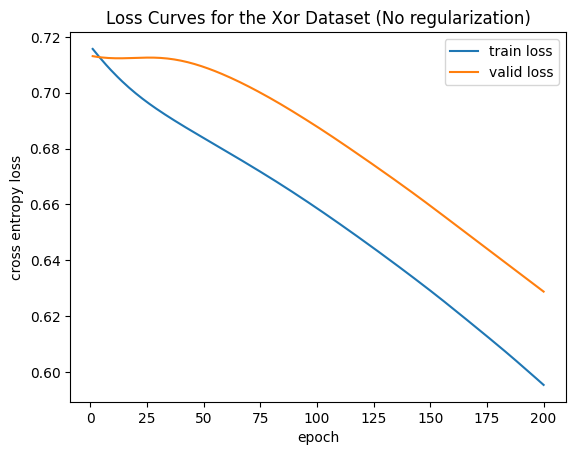

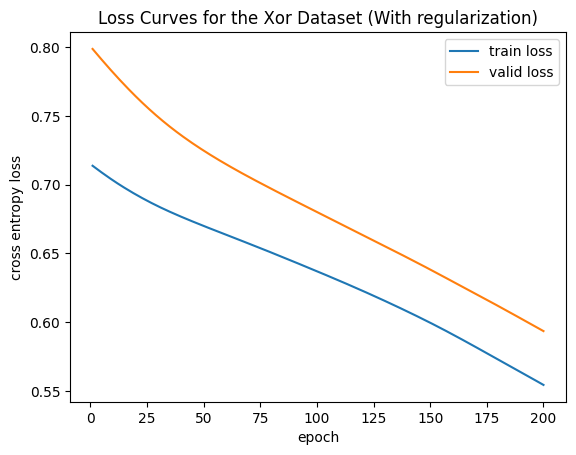

In [28]:
plot_loss_curves(train_losses_no_reg, valid_losses_no_reg, postfix="No regularization")
plot_loss_curves(train_losses_with_reg, valid_losses_with_reg, postfix="With regularization")

In [29]:
print(f"Unregularized Dataset: {csv_file_prefix.capitalize()}, Hidden Nodes: {hidden_size}, Cost Function: MCE")
test_accuracy = test(model_no_reg, test_loader)
print()
print(f"Regularized Dataset: {csv_file_prefix.capitalize()}, Hidden Nodes: {hidden_size}, Cost Function: MCE")
test_accuracy = test(model_with_reg, test_loader)

Unregularized Dataset: Xor, Hidden Nodes: 7, Cost Function: MCE
Test Accuracy: 67.5000

Regularized Dataset: Xor, Hidden Nodes: 7, Cost Function: MCE
Test Accuracy: 74.0000


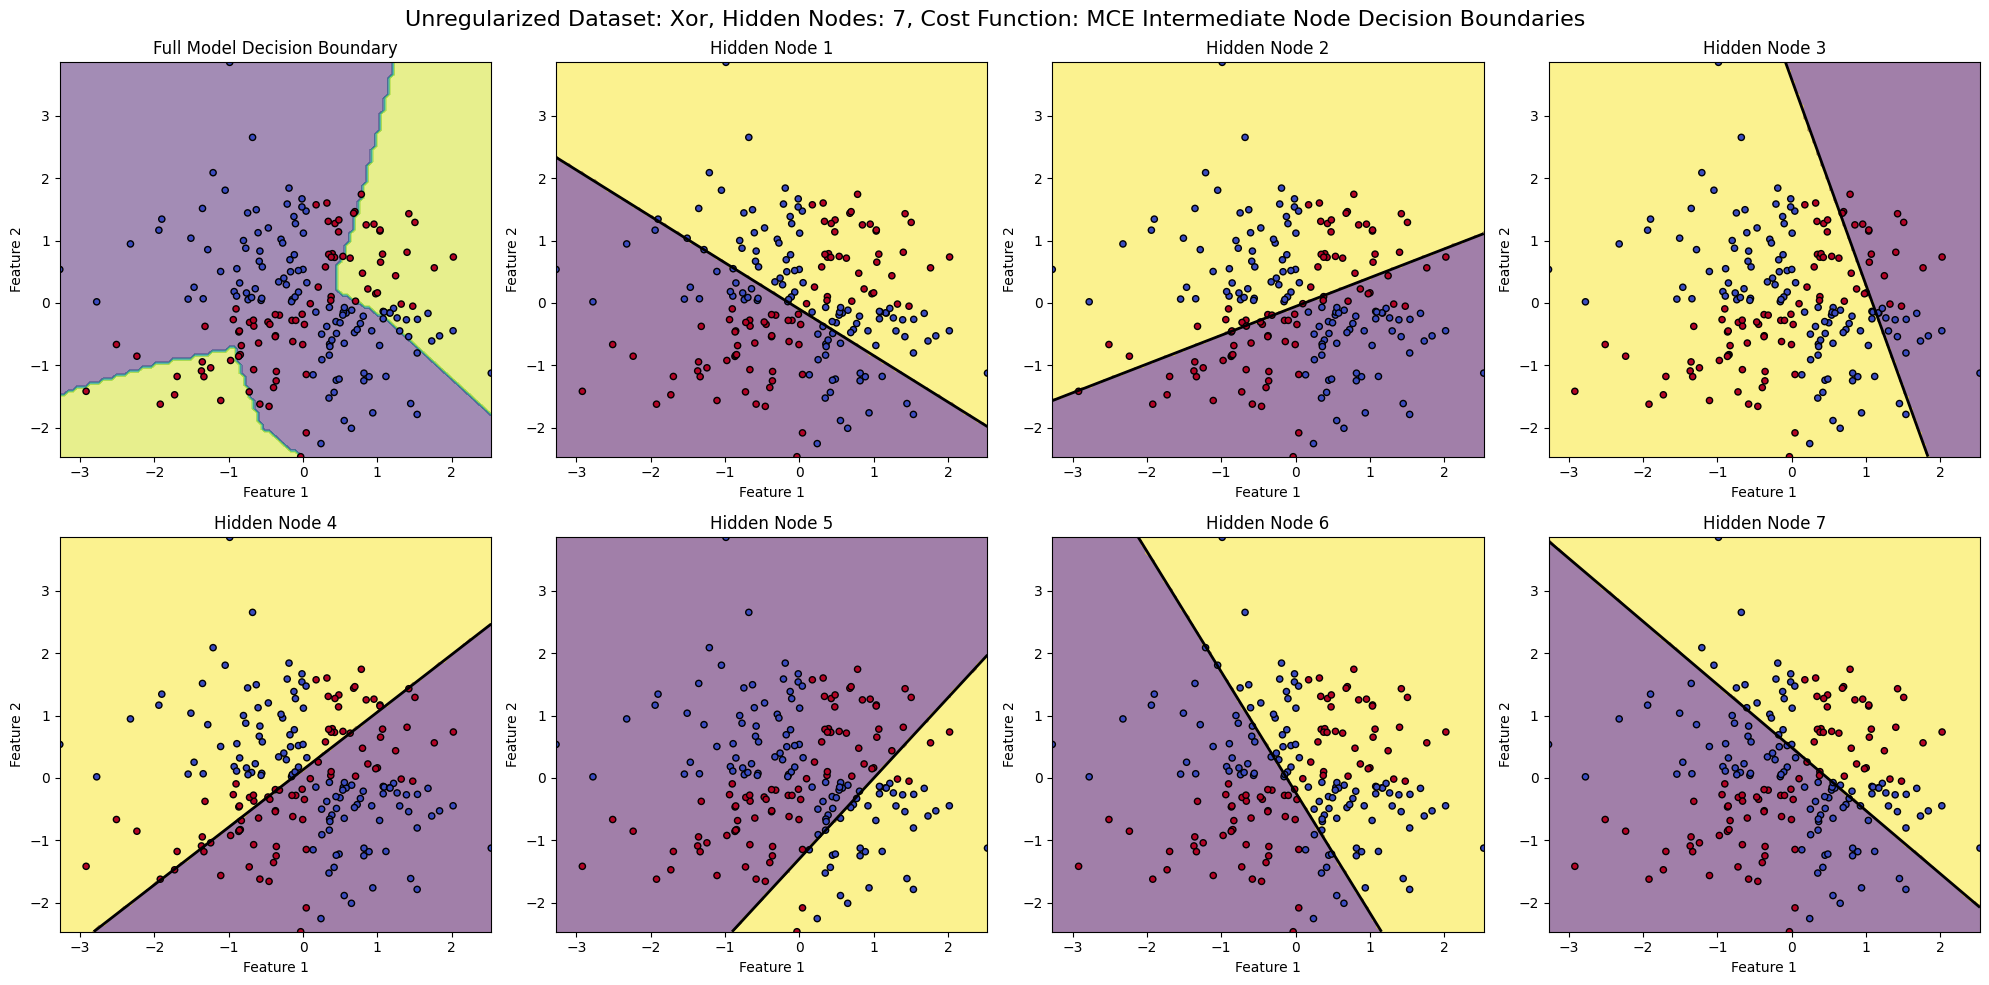

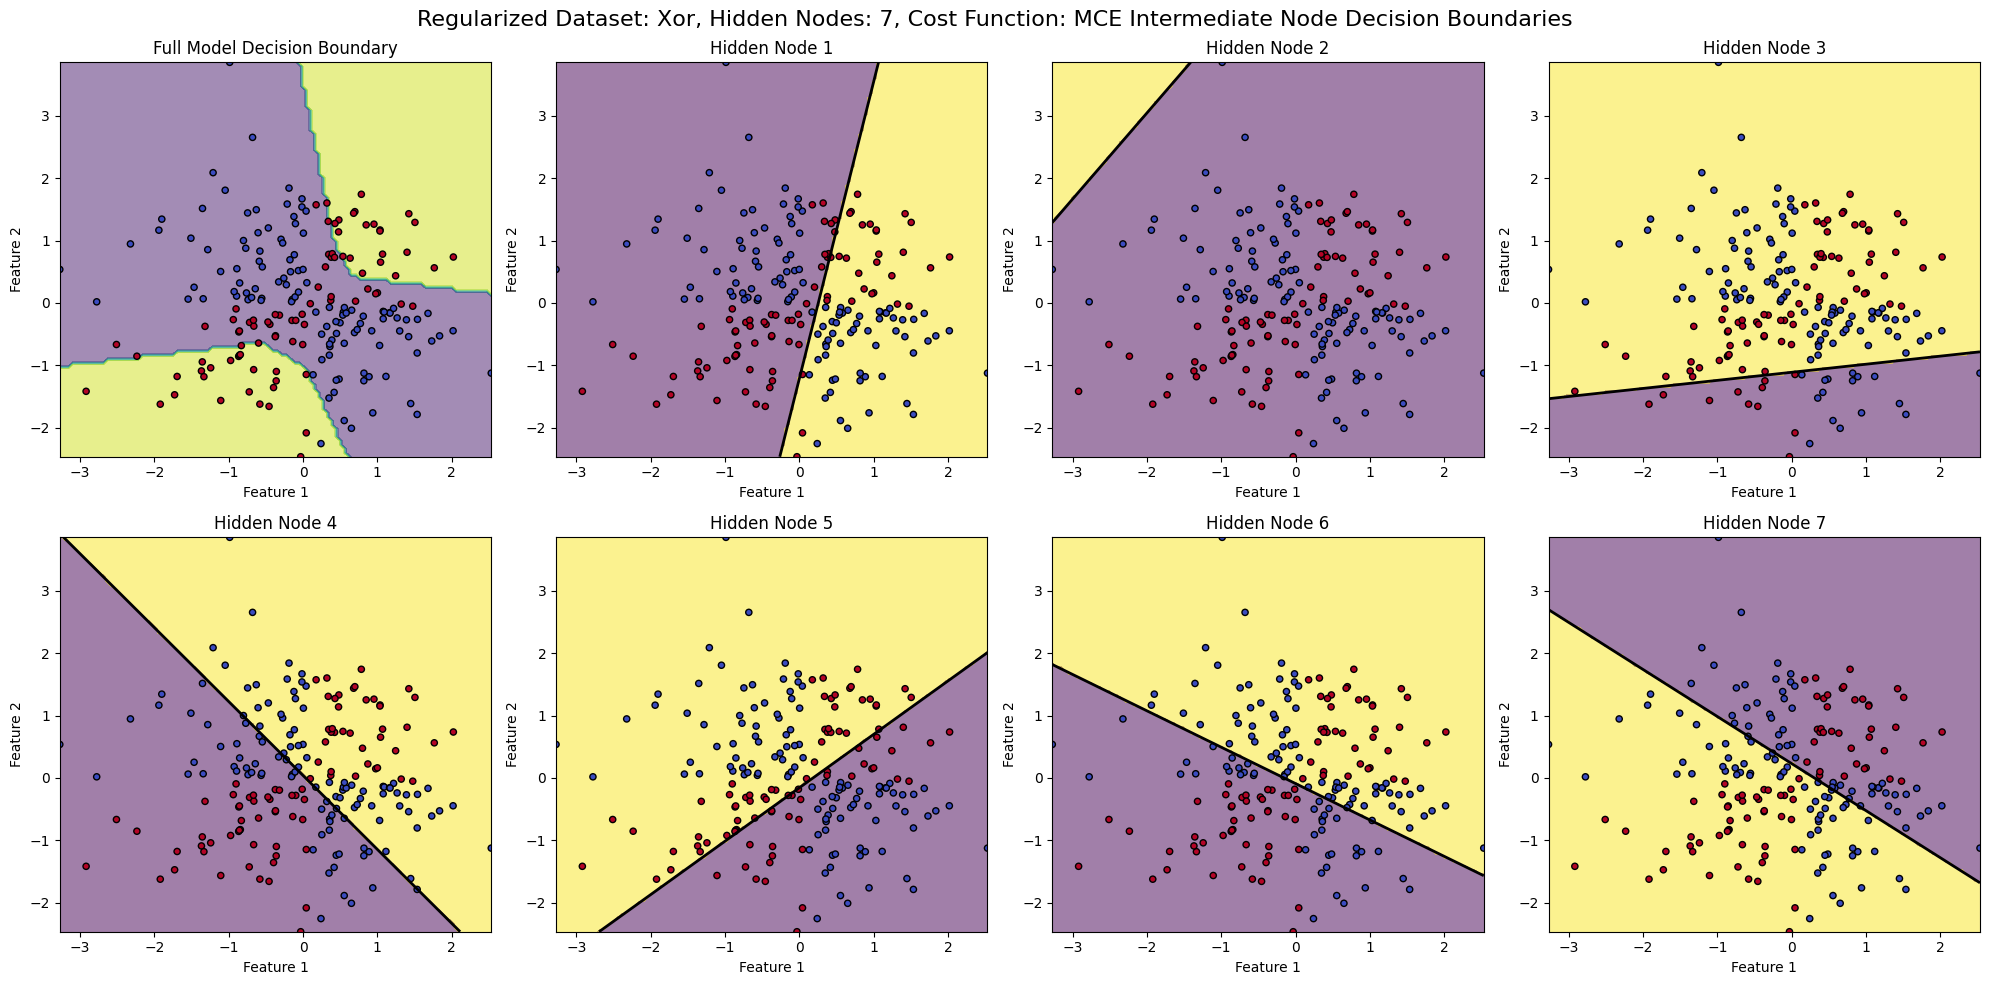

In [30]:
plot_intermediate_boundaries(model_no_reg, title=f"Unregularized Dataset: {csv_file_prefix.capitalize()}, Hidden Nodes: {hidden_size}, Cost Function: MCE")
plot_intermediate_boundaries(model_with_reg, title=f"Regularized Dataset: {csv_file_prefix.capitalize()}, Hidden Nodes: {hidden_size}, Cost Function: MCE")

# Part 4 -- PyTorch Implementation
---

*Part 4 implements regularization into our model*

---

Orthogonality regularization is used to encourage weight vectors to be orthogonal, reducing redundancy among hidden neurons and enhancing their ability to detect diverse feature patterns.

Orthogonality Regularization:
$$
R_o(W) = W^T W - I
$$

## Imports & Global Variables

In [31]:
import torch
import pandas as pd
import numpy as np

np.random.seed(42)
torch.manual_seed(42)

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [32]:
# csv_file_prefix = 'spiral'
# csv_file_prefix = 'two_gaussians'
csv_file_prefix = 'xor'
# csv_file_prefix = 'center_surround'

hidden_size = 7
lr=0.001
num_epochs = 200
lambda_val = 0.002

## Importing Data

##### Custom Dataset

In [33]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, df, scaler, transform=None):
        super().__init__()
        self.features = df.iloc[:, 1:]
        self.labels = df.iloc[:, 0]
        
        self.features = scaler.transform(self.features)

        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature, label

##### Importing the data and scaling 

In [34]:
scaler = StandardScaler()  # z-score all input features

train_df = pd.read_csv(f'{csv_file_prefix}_train.csv')

train_features = train_df.iloc[:, 1:]
features = scaler.fit(train_features)

valid_df = pd.read_csv(f'{csv_file_prefix}_valid.csv')
test_df = pd.read_csv(f'{csv_file_prefix}_test.csv')

train_dataset = SimpleDataset(df=train_df, scaler=scaler)
valid_dataset = SimpleDataset(df=valid_df, scaler=scaler)
test_dataset = SimpleDataset(df=test_df, scaler=scaler)

batch_size = len(train_features)

##### Converting into DataLoaders

In [35]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Modeling

##### Feed Forward Neural Network

In [36]:
class SimpleNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.f1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.f2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.f1(x)
        x = self.relu(x)
        x = self.f2(x)
        return x

##### Initializing model / cost function / optimizer

In [37]:
input_size = train_dataset.features.shape[1] 
output_size = len(set(train_dataset.labels))

model_no_reg = SimpleNN(input_size, hidden_size, output_size)
model_with_reg = SimpleNN(input_size, hidden_size, output_size)

criterion = torch.nn.CrossEntropyLoss()

optimizer_no_reg = torch.optim.Adam(model_no_reg.parameters(), lr=lr)
optimizer_with_reg = torch.optim.Adam(model_with_reg.parameters(), lr=lr)

##### Training the model

In [38]:
def train(model, train_loader, valid_loader, num_epochs, criterion, optimizer, orthogonality_regularization=False):
    """
    Parameters
    ----------
    model: Pytorch nn.Module model
    train_loader: training set as a DataLoader()
    valid_loader: validation set as a DataLoader()
    num_epochs: Number of epochs
    criterion: Loss function
    optimizer: Optimization function
    orthogonality_regularization: Boolean value representing if you want to use orthogonality regularization
    """
    
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)

            if orthogonality_regularization:
                sim = torch.mm(model.f1.weight, model.f1.weight.t())
    
                sim = sim - torch.eye(sim.shape[0])
                
                reg = lambda_val * torch.norm(sim, p='fro')

                loss += reg

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_valid_loss = 0.0

        with torch.no_grad():
            for features, labels in valid_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                running_valid_loss += loss.item()

        epoch_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}")
        
    return train_losses, valid_losses

In [39]:
train_losses_no_reg, valid_losses_no_reg = train(model_no_reg, train_loader, valid_loader, num_epochs, criterion, optimizer_no_reg, orthogonality_regularization=False)
train_losses_with_reg, valid_losses_with_reg = train(model_with_reg, train_loader, valid_loader, num_epochs, criterion, optimizer_with_reg, orthogonality_regularization=True)

Epoch 10/200, Train Loss: 0.7073, Valid Loss: 0.7124
Epoch 20/200, Train Loss: 0.6998, Valid Loss: 0.7125
Epoch 30/200, Train Loss: 0.6938, Valid Loss: 0.7125
Epoch 40/200, Train Loss: 0.6886, Valid Loss: 0.7115
Epoch 50/200, Train Loss: 0.6838, Valid Loss: 0.7092
Epoch 60/200, Train Loss: 0.6790, Valid Loss: 0.7060
Epoch 70/200, Train Loss: 0.6742, Valid Loss: 0.7022
Epoch 80/200, Train Loss: 0.6692, Valid Loss: 0.6978
Epoch 90/200, Train Loss: 0.6640, Valid Loss: 0.6929
Epoch 100/200, Train Loss: 0.6586, Valid Loss: 0.6878
Epoch 110/200, Train Loss: 0.6530, Valid Loss: 0.6825
Epoch 120/200, Train Loss: 0.6472, Valid Loss: 0.6769
Epoch 130/200, Train Loss: 0.6413, Valid Loss: 0.6713
Epoch 140/200, Train Loss: 0.6353, Valid Loss: 0.6655
Epoch 150/200, Train Loss: 0.6291, Valid Loss: 0.6595
Epoch 160/200, Train Loss: 0.6226, Valid Loss: 0.6533
Epoch 170/200, Train Loss: 0.6161, Valid Loss: 0.6472
Epoch 180/200, Train Loss: 0.6094, Valid Loss: 0.6410
Epoch 190/200, Train Loss: 0.6025, Va

##### Testing the model (with accuracy)

In [40]:
def test(model, test_loader):
    """
    Parameters
    ----------
    model: Pytorch nn.Module model
    test_loader: test set as a DataLoader()
    """
    
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)            

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    return test_accuracy

# Plotting Loss Curves and Decision Boundaries

Recall that L2-Regularization is a technique used to limit overfitting the training set by increases bias between the training set and test sets while decreasing the variance. You can see the difference in plots below that the training loss performance is not as good, but the validation loss still has low loss. 

In [41]:
def plot_loss_curves(train_losses, valid_losses, postfix=""):
  plt.plot(list(range(1, (num_epochs) + 1)), train_losses, label='train loss')
  plt.plot(list(range(1, (num_epochs) + 1)), valid_losses, label='valid loss')
  plt.title(f'Loss Curves for the {csv_file_prefix.capitalize()} Dataset ({postfix})')
  plt.xlabel('epoch')
  plt.ylabel('cross entropy loss')
  plt.legend()

  plt.show()
  
def plot_intermediate_boundaries(model, title=""):
    """
    Visualizes the binary decision boundaries of each hidden node in the first layer
    """
    x_min, x_max = train_dataset.features[:, 0].min(), train_dataset.features[:, 0].max()
    y_min, y_max = train_dataset.features[:, 1].min(), train_dataset.features[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    n_hidden = model.f1.weight.shape[0]
    n_rows = int(np.ceil((n_hidden + 1) / 4)) 
    
    fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5*n_rows))
    fig.suptitle(f"{title} Intermediate Node Decision Boundaries", fontsize=16)
    
    axes = axes.flatten()
    
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    viridis = plt.cm.viridis
    colors = [viridis(0), viridis(0.99)]
    
    with torch.no_grad():
        outputs = model(grid_points)
        Z = outputs.argmax(dim=1).numpy().reshape(xx.shape)
        axes[0].contourf(xx, yy, Z, alpha=0.5, cmap='viridis')
        
        for inputs, label in train_loader:
            inputs = inputs.numpy()
            label = label.numpy()
            axes[0].scatter(inputs[:, 0], inputs[:, 1], c=label, 
                          edgecolor='k', cmap='coolwarm', marker='o', s=20)
        
        axes[0].set_title('Full Model Decision Boundary')
        axes[0].set_xlabel("Feature 1")
        axes[0].set_ylabel("Feature 2")
        
        hidden_outputs = model.f1(grid_points)
        
        for i in range(n_hidden):
            ax = axes[i+1]
            
            Z = (hidden_outputs[:, i] > 0).numpy().reshape(xx.shape)
            ax.contourf(xx, yy, Z, levels=1, colors=colors, alpha=0.5)
            
            Z_boundary = hidden_outputs[:, i].numpy().reshape(xx.shape)
            ax.contour(xx, yy, Z_boundary, levels=[0], colors='black', linewidths=2)
            
            for inputs, label in train_loader:
                inputs = inputs.numpy()
                label = label.numpy()
                ax.scatter(inputs[:, 0], inputs[:, 1], c=label, 
                          edgecolor='k', cmap='coolwarm', marker='o', s=20)
            
            ax.set_title(f'Hidden Node {i+1}')
            ax.set_xlabel("Feature 1")
            ax.set_ylabel("Feature 2")
    
    for i in range(n_hidden + 1, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

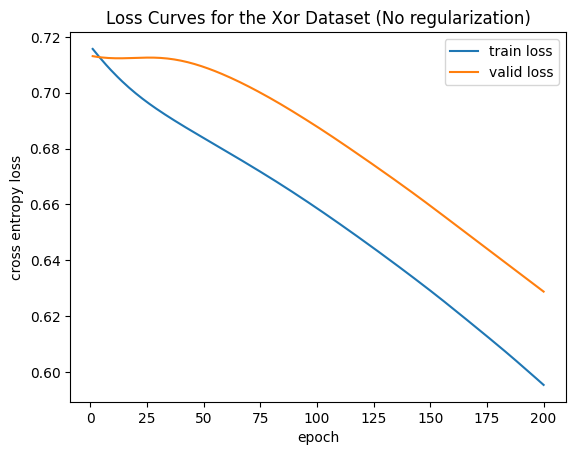

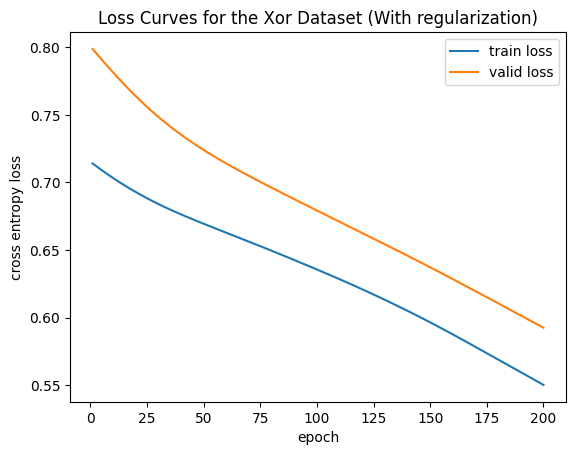

In [42]:
plot_loss_curves(train_losses_no_reg, valid_losses_no_reg, postfix="No regularization")
plot_loss_curves(train_losses_with_reg, valid_losses_with_reg, postfix="With regularization")

In [43]:
print(f"Unregularized Dataset: {csv_file_prefix.capitalize()}, Hidden Nodes: {hidden_size}, Cost Function: MCE")
test_accuracy = test(model_no_reg, test_loader)
print()
print(f"Regularized Dataset: {csv_file_prefix.capitalize()}, Hidden Nodes: {hidden_size}, Cost Function: MCE")
test_accuracy = test(model_with_reg, test_loader)

Unregularized Dataset: Xor, Hidden Nodes: 7, Cost Function: MCE
Test Accuracy: 67.5000

Regularized Dataset: Xor, Hidden Nodes: 7, Cost Function: MCE
Test Accuracy: 74.0000


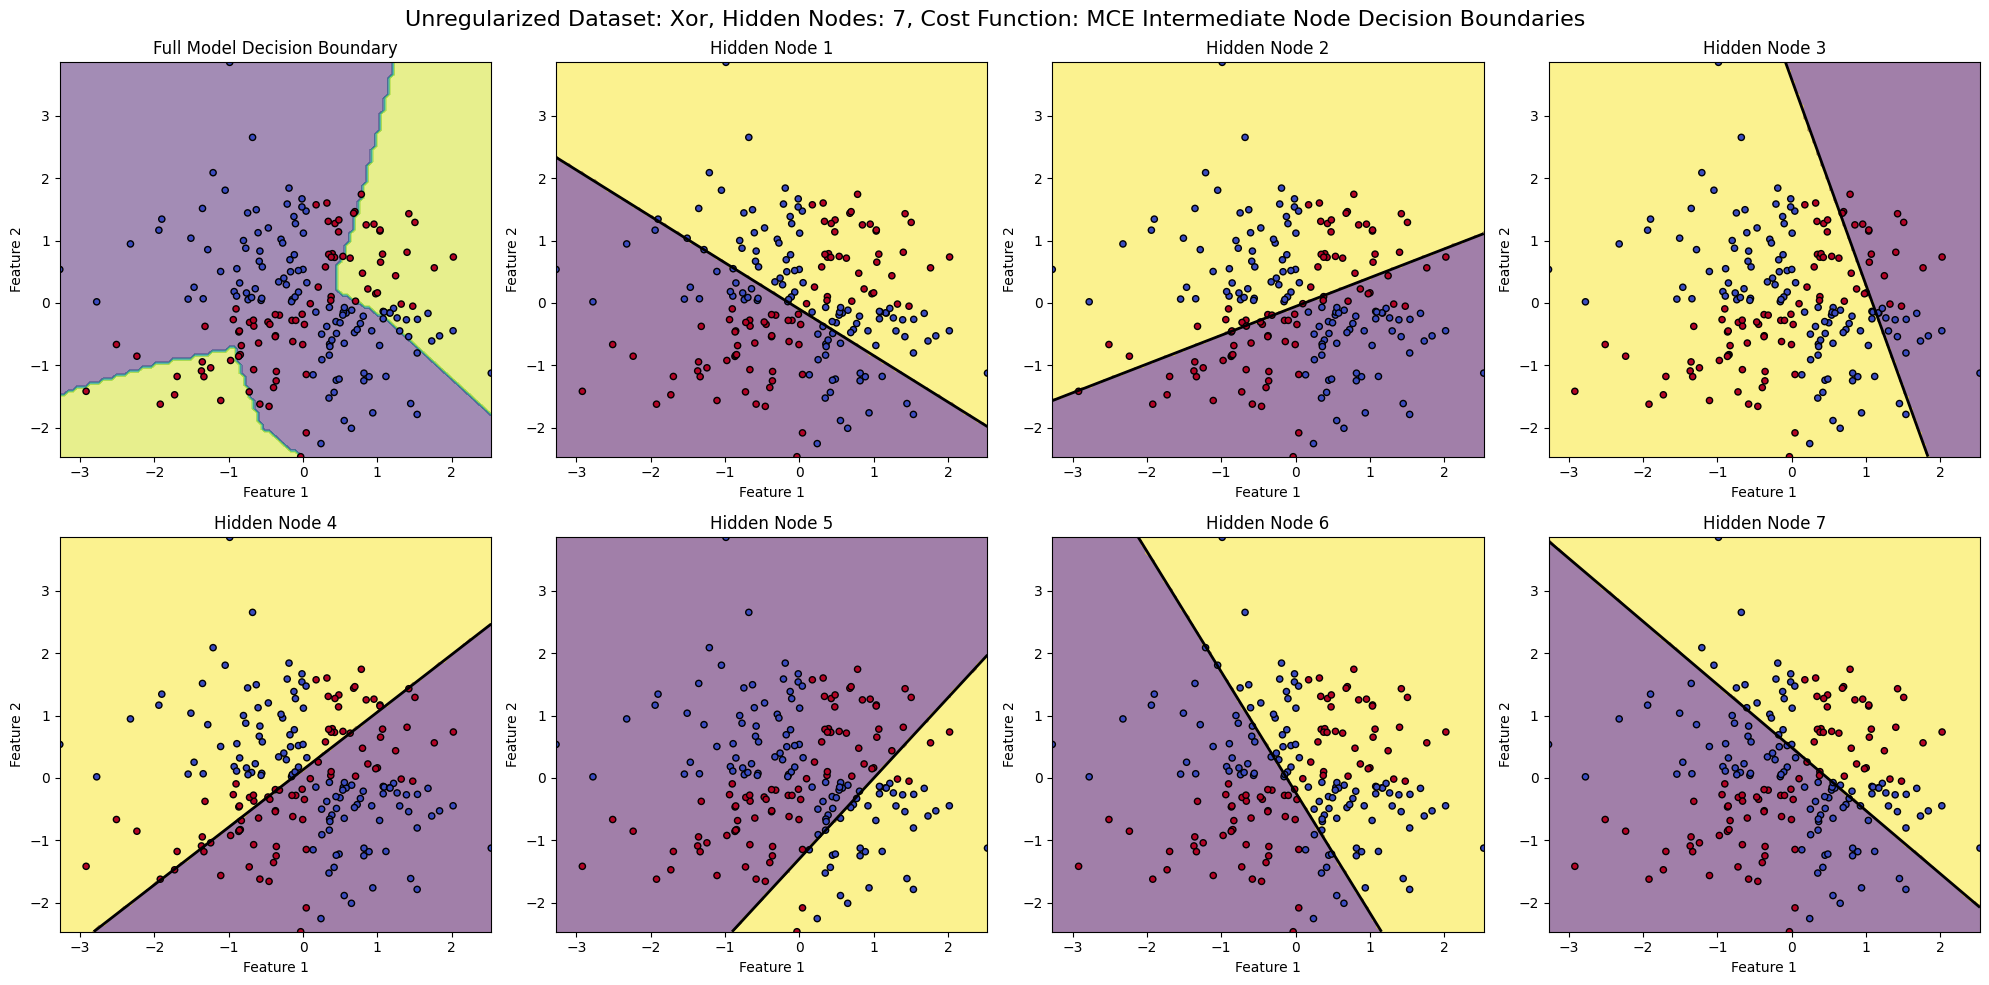

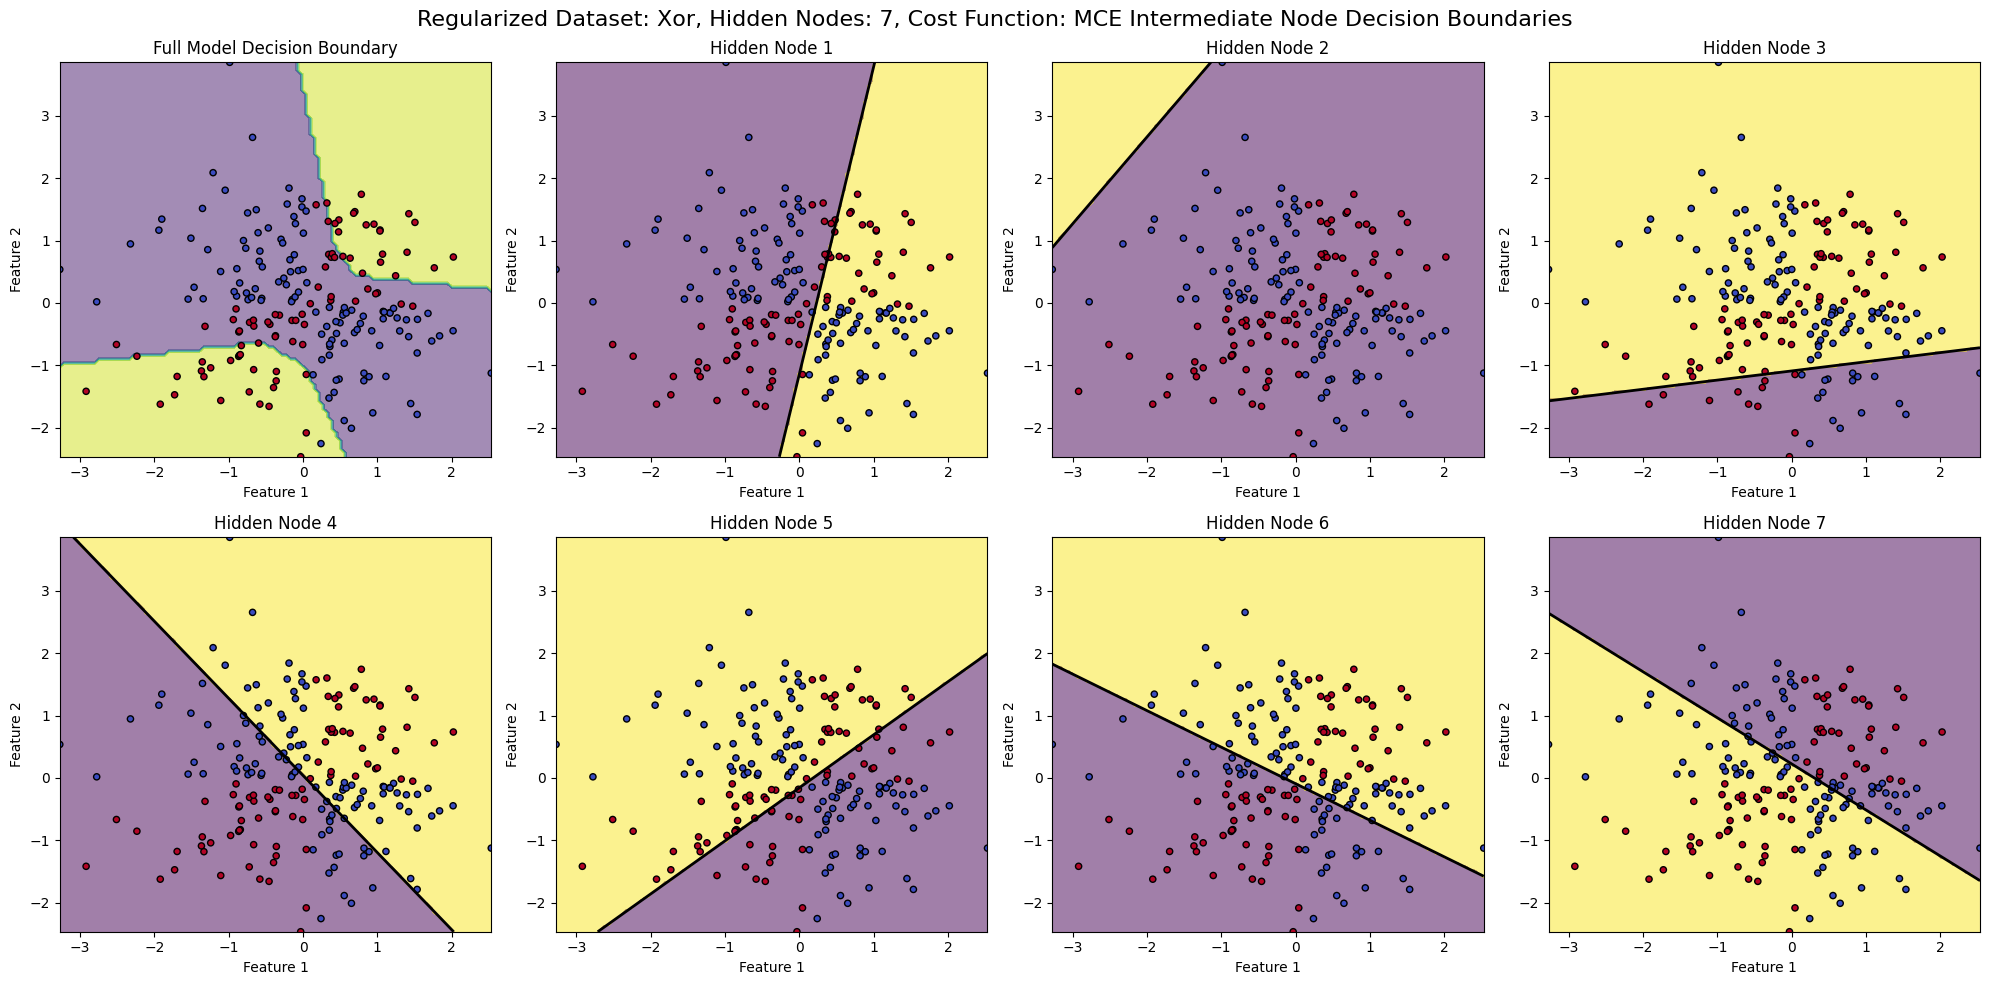

In [44]:
plot_intermediate_boundaries(model_no_reg, title=f"Unregularized Dataset: {csv_file_prefix.capitalize()}, Hidden Nodes: {hidden_size}, Cost Function: MCE")
plot_intermediate_boundaries(model_with_reg, title=f"Regularized Dataset: {csv_file_prefix.capitalize()}, Hidden Nodes: {hidden_size}, Cost Function: MCE")